<a href="https://colab.research.google.com/github/vasanthsai26/Corp-favorita-store-sales-Time-Series-Forecasting/blob/main/object_localization_and_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OxfordIIITPet Localization and Classification - PyTorch




**Problem Statement**

- Classify and Localize the Pets in the images



**Dataset**



> The Oxford-IIIT Pet Dataset





<img src="https://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg" alt="object_localzation_segmentation" width="600" height="400">


- The Oxford Pets dataset (also known as the "dogs vs cats" dataset) is a collection of images and annotations labeling various breeds of dogs and cats. There are approximately 100 examples of each of the 37 breeds. This dataset contains the object detection portion of the original dataset with bounding boxes around the animals' heads.

> Evaluation Metric

**IOU (Intersection over Union)**

- IOU(Intersection over Union) is a term used to describe the extent of overlap of two boxes. The greater the region of overlap, the greater the IOU.
- It is used to evaluate the performance of object detection by comparing the ground truth bounding box to the preddicted bounding box
-  For example in the image below, we have a green box, and a red box. The green box represents the  ground truth box, and the red box represents the prediction from our model. The aim of this model would be to keep improving its prediction, until the red box and the green box perfectly overlap, i.e the IOU between the two boxes becomes equal to 1.


<img src="https://i.imgur.com/INoHzQF.jpg" alt="IOU_example" width="600" height="400">

- IOU is also used in non max suppression, which is used to eliminate multiple boxes that surround the same object, based on which box has a higher confidence.

<img src="https://i.imgur.com/NO8nAQx.png" alt="IOU_example" width="500" height="350">

## Data Gathering and Initial Insights

### Installing and Importing the required packages

In [1]:
## Installing the libraries
!pip install -U git+https://github.com/albumentations-team/albumentations --q
!pip install timm --q
!pip install --upgrade opencv-contrib-python --q
!pip install torchinfo --q

  Preparing metadata (setup.py) ... done


In [47]:
## General Imports
import random
import math
import os
import xml.etree.ElementTree as et

from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

## Data Analysis packages
import numpy as np
import pandas as pd

## Data Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# We will be reading images using OpenCV
import cv2

## for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## torch imports
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary 
from torchvision import datasets


## Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2 

## sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

### Project Configurations

In [4]:
#DIR CONFIGS
ROOT_DIR = "/content"
IMAGE_DIR = "/content/data/oxford-iiit-pet/images"
ANNOT_DIR = "/content/data/oxford-iiit-pet/annotations" 

## DATA CONFIGS
IMG_SIZE = 224
NUM_CLASSES = 37
BOUNDING_BOX_POINTS = 4
SPECIES_DICT = { 0 : "Cat", 1 : "Dog"}

## TRANING CONFIGS 
SCALE = 1.1
SEED = 42
EPOCHS = 75 
BATCH_SIZE = 32

- General Helper Functions

In [22]:
def seed_everything(TORCH_SEED: int) -> None:
    """
    Sets the manual SEED  
    """
    random.seed(TORCH_SEED)  
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> str:
    """
    Returns the default device available
    """
    return "cuda" if torch.cuda.is_available() else "cpu"

### Downloading and Loading the Dataset

#### Downloading the data from torchvision datasets

In [23]:
train_val_data = datasets.OxfordIIITPet(root="./data",
                                        split='trainval',
                                        download=True,
                                        target_types=["category","segmentation"])
test_data = datasets.OxfordIIITPet(root="./data",
                                   split='test',
                                   download=True,
                                   target_types=["category","segmentation"])

#### Data Preprocessing

In [38]:
def get_data_dict():
    """
    Return data dict structure
    """
    data_dict = {
        "image_name" : list(),
        "image_path" : list(),
        "xmin": list(),
        "ymin": list(),
        "xmax": list(),
        "ymax": list(),
        "class_label": list(),
        "species_label": list() 
        }
    return data_dict

In [39]:
def get_BB(xml_path):
    """
    Parse the XML file and the ground truth Bounding box coordinates
    """
    #parse the annotations
    tree = et.parse(xml_path)
    root = tree.getroot()

    bbox = root.find("object/bndbox")

    xmin = bbox.find('xmin').text
    xmax = bbox.find('xmax').text

    ymin = bbox.find('ymin').text
    ymax = bbox.find('ymax').text

    return ((int(xmin),int(ymin)),(int(xmax),int(ymax)))

In [40]:
def validate_file(file):
    """
    Return image path and XML file path if exist
    """
    img_file = file + ".jpg"
    xml_file = file + ".xml"

    img_path = os.path.join(IMAGE_DIR,img_file)
    xml_path = os.path.join(ANNOT_DIR,"xmls",xml_file)

    if os.path.isfile(img_path):
        if os.path.isfile(xml_path):
            return (img_path,xml_path)
        else:
            print(f"XML file for {img_file} is not available")
            return (img_path,None)

    print(f"Image file for {img_file} is not available")
    return (None,None)

In [78]:
def add_data(img_path,xml_path,data_dict):
    """
    Add the data to the data_dict by parsing the img_path and xml_path
    """
    image = os.path.basename(img_path)
    data_dict["image_name"].append(image)
    data_dict["image_path"].append(img_path)

    (xmin,ymin),(xmax,ymax) = get_BB(xml_path)
    data_dict["xmin"].append(xmin)
    data_dict["ymin"].append(ymin)
    data_dict["xmax"].append(xmax)
    data_dict["ymax"].append(ymax)

    class_name = "_".join(image.split("_")[:-1])
    species_label = "Cat" if class_name[0].isupper() else "Dog"

    data_dict["class_label"].append(class_name.lower())
    data_dict["species_label"].append(species_label)  

In [79]:
def get_data(image_path=IMAGE_DIR,
             annot_path=ANNOT_DIR,
             val_split = 0.2):
    """
    Read, Parse and return the train and validation 
    """

    with open(os.path.join(annot_path, "trainval.txt"),"r") as train_val_txt:
        ## read the train val file
        train_val_images = train_val_txt.readlines()
        
        data_dict = get_data_dict()

        for image in train_val_images:

            image = image.strip().split()
            img_path,xml_path = validate_file(image[0])

            if img_path and xml_path:
                add_data(img_path,xml_path,data_dict)

        # Prepare train and validation set
        data_df = pd.DataFrame(data_dict).sort_values(by="class_label")

        # Encode the class label
        encoder = LabelEncoder().fit(data_df["class_label"])
        data_df["class_idx"] = encoder.transform(data_df["class_label"])

        # make train and val split
        train_df, val_df = train_test_split(data_df, 
                                            test_size = val_split, 
                                            stratify=data_df['class_label'])
    return train_df,val_df

- loading the Data

In [80]:
train_df,val_df = get_data()

XML file for Abyssinian_104.jpg is not available
XML file for Bengal_111.jpg is not available
XML file for samoyed_10.jpg is not available
XML file for Bengal_175.jpg is not available
XML file for Egyptian_Mau_14.jpg is not available
XML file for Egyptian_Mau_156.jpg is not available
XML file for Egyptian_Mau_186.jpg is not available
XML file for Ragdoll_199.jpg is not available
XML file for saint_bernard_15.jpg is not available


##Data Exploration

In [81]:
train_df.head()

,image_name,image_path,xmin,ymin,xmax,ymax,class_label,species_label,class_idx
3003,Persian_187.jpg,/content/data/oxford-iiit-pet/images/Persian_1...,162,16,392,283,persian,Cat,23
3613,wheaten_terrier_184.jpg,/content/data/oxford-iiit-pet/images/wheaten_t...,126,80,278,186,wheaten_terrier,Dog,35
2616,great_pyrenees_180.jpg,/content/data/oxford-iiit-pet/images/great_pyr...,140,44,239,137,great_pyrenees,Dog,15
3526,staffordshire_bull_terrier_154.jpg,/content/data/oxford-iiit-pet/images/staffords...,157,114,355,247,staffordshire_bull_terrier,Dog,34
495,British_Shorthair_156.jpg,/content/data/oxford-iiit-pet/images/British_S...,190,44,345,196,british_shorthair,Cat,9


In [82]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2936 entries, 3003 to 657
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     2936 non-null   object
 1   image_path     2936 non-null   object
 2   xmin           2936 non-null   int64 
 3   ymin           2936 non-null   int64 
 4   xmax           2936 non-null   int64 
 5   ymax           2936 non-null   int64 
 6   class_label    2936 non-null   object
 7   species_label  2936 non-null   object
 8   class_idx      2936 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 229.4+ KB


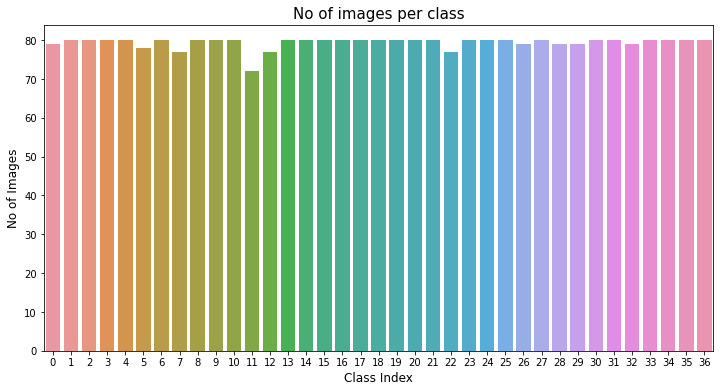

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(12,6))
sns.countplot(x=train_df["class_idx"])
axes.set_xlabel("Class Index",fontsize="large")
axes.set_ylabel("No of Images",fontsize="large")
axes.set_title("No of images per class",fontsize=15)
fig.show();

- The Average no of images per class 80

In [85]:
class_to_idx = train_df.groupby(by=["class_idx","class_label","species_label"]).size().to_frame().reset_index()
class_to_idx = class_to_idx.set_index("class_idx").loc[:,["class_label","species_label"]]
class_to_idx.head()

,class_label,species_label
class_idx,,
0,abyssinian,Cat
1,american_bulldog,Dog
2,american_pit_bull_terrier,Dog
3,basset_hound,Dog
4,beagle,Dog


- Sample Images

In [105]:
def draw_BB(file):
    img_path,xml_path = validate_file(file)

    if img_path:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if xml_path:
        pt1, pt2 = get_BB(xml_path)
        img = cv2.rectangle(img, pt1, pt2, (0,255,0), 2)
    if img_path:
        breed = file.split("_")[0]
        species = "Cat" if breed[0].isupper() else "Dog"
        plt.title(f"Breed : {breed} | Species : {species}")

        plt.imshow(img)
        plt.axis('off')
        plt.show();
    else:
        pass

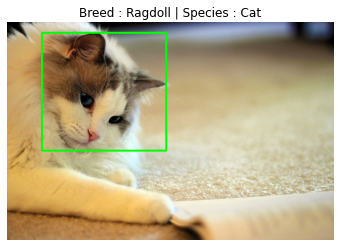

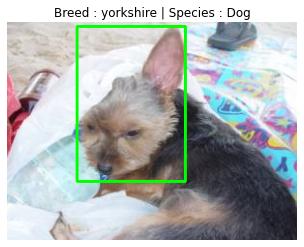

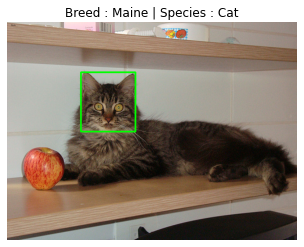

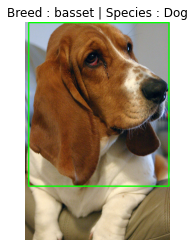

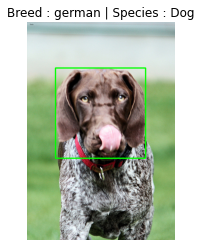

In [107]:
for _ in range(5):
    file = train_df.sample(1)["image_name"].to_list()[0].split(".")[0]
    draw_BB(file)

In [13]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

def denormalize(images, means=[0.485, 0.456, 0.406], stds=[0.2023, 0.1994, 0.2010],device=get_device()):
    means = torch.tensor(means).reshape(1, 3, 1, 1).to(device)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1).to(device)
    return (images * stds + means)


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2  
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    iou = intersection / (box1_area + box2_area - intersection + 1e-6)

    return iou

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [14]:
train_df.head()

,image_name,image_path,xmin,ymin,xmax,ymax,class_label,species_label,class_idx
3142,Ragdoll_172.jpg,/content/data/oxford-iiit-pet/images/Ragdoll_1...,256,1,425,223,ragdoll,0,26
1421,saint_bernard_125.jpg,/content/data/oxford-iiit-pet/images/saint_ber...,84,76,345,353,saint_bernard,1,28
1789,wheaten_terrier_142.jpg,/content/data/oxford-iiit-pet/images/wheaten_t...,272,179,379,266,wheaten_terrier,1,35
458,British_Shorthair_110.jpg,/content/data/oxford-iiit-pet/images/British_S...,126,40,411,256,british_shorthair,0,9
2978,Persian_161.jpg,/content/data/oxford-iiit-pet/images/Persian_1...,147,12,348,204,persian,0,23


/content/data/oxford-iiit-pet/images/english_setter_146.jpg /content/data/oxford-iiit-pet/annotations/xmls/english_setter_146.xml


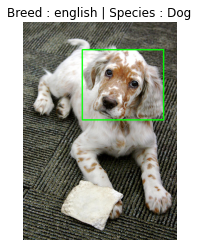

In [15]:
draw_BB("english_setter_146")

In [10]:
class oxfordDataset(Dataset):
    def __init__(self,data_df,augmentations=None):
        self.data_df = data_df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self,idx):
        img_details = self.data_df.iloc[idx]

        img_path = img_details["image_path"]
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        class_label = torch.tensor(img_details["class_idx"], dtype=torch.long)
        xmin = img_details["xmin"]
        ymin = img_details["ymin"]
        xmax = img_details["xmax"]
        ymax = img_details["ymax"]

        bbox=[[xmin,ymin,xmax,ymax]]
        if self.augmentations:
            data = self.augmentations(image = image, bboxes = bbox, class_labels=[class_label])
            try: 
                image = data["image"]
                bboxes = torch.tensor(data["bboxes"][0], dtype=torch.float32)
                #class_label = data["class_labels"]
            except IndexError:
                print(img_path,idx)
                print(data)
        return (image.to(torch.float),class_label,bboxes)

In [11]:


train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMG_SIZE * SCALE)),
        A.PadIfNeeded(
            min_height=int(IMG_SIZE * SCALE),
            min_width=int(IMG_SIZE * SCALE),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMG_SIZE, height=IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.2023, 0.1994, 0.2010], max_pixel_value=255),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"],),
)
val_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMG_SIZE),
        A.PadIfNeeded(
            min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.RandomCrop(width=IMG_SIZE, height=IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.2023, 0.1994, 0.2010], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']),
)

In [12]:
train_data = oxfordDataset(train_df,train_transforms)
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
val_data = oxfordDataset(val_df,val_transforms)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE*2)

## Model RESNET

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self,num_layers,in_channels,out_channels,identity_downsample=None,stride=1):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Not a Valid architecture'

        super(ResidualBlock,self).__init__()
        self.num_layers = num_layers
        self.expansion = 1 if self.num_layers < 50 else 4

        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                               kernel_size=1,stride=1,padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        if self.num_layers >= 50:

            self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels,
                                   kernel_size=3,stride=stride,padding=1,bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.conv3 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels * self.expansion,
                                    kernel_size=1, stride=1, padding=0,bias=False)
            
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                                   kernel_size=3,stride=stride,padding=1,bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.conv3 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels * self.expansion,
                                    kernel_size=3, stride=1, padding=1,bias=False)
            
        
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.downsample = identity_downsample

    def forward(self,x):
        identity = x
        if self.num_layers >= 50:
            x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if self.downsample is not None and self.num_layers >= 50:
            identity = self.downsample(identity)
        x = self.relu(x + identity)
        return x

In [16]:
class ResNet(nn.Module):
    def __init__(self, 
                 num_layers, 
                 block, 
                 image_channels, 
                 num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '

        super(ResNet,self).__init__()

        self.expansion = 1 if num_layers < 50 else 4
        self.layers = self.get_layers(num_layers)

        ## num_out = ((num_in + 2*padding - kernal) / stride) + 1 
        ## conv1 layer
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=image_channels,out_channels=self.in_channels,
                               kernel_size=(7,7), stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=self.in_channels)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, self.layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, self.layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, self.layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, self.layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Linear(512 * self.expansion, num_classes)
    
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        return x

    def make_layers(self,num_layers,block,num_residual_blocks,intermediate_channels,stride):
        layers = []
        downsample = None
        if num_layers >= 50: 
            downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, 
                                                      kernel_size=1, stride=stride,bias=False),
                                                    nn.BatchNorm2d(intermediate_channels*self.expansion))
        
        layers.append(block(num_layers, self.in_channels, intermediate_channels, downsample, stride))

        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

    def get_layers(self,num_layers):
        self.layer_map = {
            18 : [2, 2, 2, 2],
            34 : [3, 4, 6, 3],
            50 : [3, 4, 6, 3],
            101: [3, 4, 23, 3],
            152: [3, 8, 36, 3]
        }
        return self.layer_map.get(num_layers,None)

In [44]:
class ObjLocModel(nn.Module):
    def __init__(self,num_layers,image_channels,num_classes,bb_points,block,pretrained):
        super(ObjLocModel,self).__init__()
        self.num_layers = num_layers
        self.image_channels = image_channels
        self.custom_resnet = block
        self.num_classes = num_classes
        self.bb_points = bb_points
        self.backbone= self.get_backbone(pretrained)
        self.in_features = 512 if num_layers < 50 else 2048

        self.fc_classification = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(in_features=1* 1* self.in_features, out_features=1 * 1 * self.in_features),
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=num_classes)
        )
        
        self.fc_bounding_box = nn.Sequential(
            nn.Conv2d(in_channels=self.in_features,out_channels=2048,
                               kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=2048),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.Conv2d(in_channels=2048,out_channels=1024,
                               kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.Conv2d(in_channels=4096,out_channels=self.in_features,
                      kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=self.in_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.AdaptiveAvgPool2d((1,1)),

            nn.Flatten(),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=1 * 1 * self.in_features),
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=bb_points)
        )
    def forward(self,x):
        x = self.backbone(x)
        y_classification = self.fc_classification(x)
        y_bounding_box = self.fc_bounding_box(x)
        return y_classification,y_bounding_box
    
    def get_backbone(self,pretrained):
        if pretrained:
            weights,model = self.get_model_details(self.num_layers)
            pretrained_model = model(weights=weights.DEFAULT)
            for param in pretrained_model.parameters():
                param.requires_grad = False 
            layers = list(pretrained_model.children())[:8]
            backbone = nn.Sequential(*layers)
            return backbone
        else:
            backbone =  self.custom_resnet(num_layers=self.num_layers,
                                      block=ResidualBlock,
                                      image_channels=self.image_channels,
                                      num_classes=self.num_classes)
            for c in backbone.children():
                if isinstance(c, nn.Conv2d):
                    nn.init.xavier_uniform_(c.weight)
            return backbone
        
    def get_model_details(self,num_layers):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        resnet_models = {
            18 : [torchvision.models.ResNet18_Weights,torchvision.models.resnet18],
            34 : [torchvision.models.ResNet34_Weights,torchvision.models.resnet34],
            50 : [torchvision.models.ResNet50_Weights,torchvision.models.resnet50],
            101: [torchvision.models.ResNet101_Weights,torchvision.models.resnet101],
            152: [torchvision.models.ResNet152_Weights,torchvision.models.resnet152]
        }
        return resnet_models[num_layers]

In [38]:
model = ObjLocModel(num_layers=50,
                    image_channels=3,
                    num_classes=NUM_CLASSES,
                    bb_points=BOUNDING_BOX_POINTS,
                    block=ResNet,
                    pretrained=True)

In [39]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjLocModel (ObjLocModel)                     [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (backbone)                       [32, 3, 224, 224]    [32, 2048, 7, 7]     --                   False
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (1)                        [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (2)                               [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (4)                         [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56,

In [40]:
import torch
from tqdm.auto import tqdm
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               class_loss_fn: torch.nn.Module,
               bbox_loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               only_bbox : bool,
               grad_clip: float):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc , train_iou = 0, 0, 0

    # Loop through data loader data batches
    for batch_id, (X,y_label, y_bbox) in tqdm(enumerate(dataloader)):
        # Send data to target device
        (X,y_label, y_bbox) = X.to(device), y_label.to(device),y_bbox.to(device)

        # 1. Forward pass
        y_label_pred,y_bbox_pred = model(X)

        # 2. Calculate  and accumulate loss
        if only_bbox :
            loss = bbox_loss_fn(y_bbox_pred,y_bbox)
            train_loss += loss.item() 
        else:    
            label_loss = class_loss_fn(y_label_pred,y_label)
            bbox_loss = bbox_loss_fn(y_bbox_pred,y_bbox)
            loss = label_loss + bbox_loss
            train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        with torch.no_grad():
            y_pred_class = torch.argmax(torch.softmax(y_label_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y_label).sum().item()/len(y_pred_class)
            train_iou += intersection_over_union(y_bbox_pred,y_bbox,"corners").sum().item()/len(y_bbox_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    scheduler.step(train_loss)
    train_acc = train_acc / len(dataloader)
    train_iou = train_iou / len(dataloader)
    return train_loss, train_acc,train_iou

In [41]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              class_loss_fn: torch.nn.Module,
              bbox_loss_fn:torch.nn.Module,
              device: torch.device,
              only_bbox: bool):
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc, test_iou = 0, 0,0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X,y_label, y_bbox) in tqdm(enumerate(dataloader)):
            # Send data to target device
            (X,y_label, y_bbox) = X.to(device), y_label.to(device),y_bbox.to(device)

        # 1. Forward pass
            y_label_pred,y_bbox_pred = model(X)

            # 2. Calculate and accumulate loss
            if only_bbox:
                loss = bbox_loss_fn(y_bbox_pred,y_bbox)
                test_loss += loss.item()
            else:
                label_loss = class_loss_fn(y_label_pred,y_label)
                bbox_loss = bbox_loss_fn(y_bbox_pred,y_bbox)
                loss = label_loss + bbox_loss
                test_loss += loss.item()

            # Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_label_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y_label).sum().item()/len(y_pred_class)
            test_iou += intersection_over_union(y_bbox_pred,y_bbox,'corners').sum().item()/len(y_bbox_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    test_iou = test_iou/ len(dataloader)
    return test_loss, test_acc, test_iou

In [42]:
# Define loss and optimizer and scheduler
seed_everything(42)
weight_decay = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
classification_loss_fn = nn.CrossEntropyLoss()
regression_loss_fn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.4,patience=3,verbose=True)
ONLY_BBOX = False

In [43]:
torch.cuda.empty_cache()
GRAD_CLIP = 0.1
history = []
TOTAL_VAL_LOSS,TOTAL_VAL_IOU = 0,0
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc,train_iou = train_step(model,
                                                 train_dataloader,
                                                 classification_loss_fn,
                                                 regression_loss_fn,
                                                 optimizer,
                                                 device,
                                                 ONLY_BBOX,
                                                 GRAD_CLIP)
    print(f"{epoch} : train_loss {train_loss} | train_acc {train_acc} | train_iou {train_iou}")
    val_loss, val_acc, val_iou = test_step(model,
                                              val_dataloader,
                                              classification_loss_fn,
                                              regression_loss_fn,
                                              device,
                                              ONLY_BBOX)
    print(f"{epoch} : val_loss {val_loss} | test_acc {val_acc} | test_iou {val_iou}")
    if val_iou > TOTAL_VAL_IOU:
        TOTAL_VAL_IOU = val_iou
        save_model(model,"models","best-model-more-layers.pth")

  0%|          | 0/75 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0 : train_loss 72.85291296502818 | train_acc 0.5893342391304348 | train_iou 0.1870443465871875


0it [00:00, ?it/s]

0 : val_loss 33.97612508138021 | test_acc 0.7898605510752689 | test_iou 0.35566486770747807
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

1 : train_loss 46.243589878082275 | train_acc 0.7741168478260869 | train_iou 0.2811118348137192


0it [00:00, ?it/s]

1 : val_loss 33.98361031214396 | test_acc 0.844800067204301 | test_iou 0.4040352811095535
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

2 : train_loss 40.79733268074367 | train_acc 0.8164628623188406 | train_iou 0.38916648379054625


0it [00:00, ?it/s]

2 : val_loss 33.624165852864586 | test_acc 0.8343834005376344 | test_iou 0.49203734876968525
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

3 : train_loss 37.314924613289215 | train_acc 0.8477128623188406 | train_iou 0.45607884573763696


0it [00:00, ?it/s]

3 : val_loss 34.78715181350708 | test_acc 0.848622311827957 | test_iou 0.5552289005248777
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

4 : train_loss 34.508318921794064 | train_acc 0.8735280797101449 | train_iou 0.46999660361072293


0it [00:00, ?it/s]

4 : val_loss 43.03319072723389 | test_acc 0.8474042338709676 | test_iou 0.49046560088472985


0it [00:00, ?it/s]

5 : train_loss 34.95870842104373 | train_acc 0.8867753623188406 | train_iou 0.47441243531479355


0it [00:00, ?it/s]

5 : val_loss 39.399454752604164 | test_acc 0.8641633064516129 | test_iou 0.517303437555349


0it [00:00, ?it/s]

6 : train_loss 36.34411498774653 | train_acc 0.8845108695652174 | train_iou 0.4932763364867888


0it [00:00, ?it/s]

6 : val_loss 41.97943385442098 | test_acc 0.8680695564516129 | test_iou 0.5345066452539096


0it [00:00, ?it/s]

7 : train_loss 36.34417308931766 | train_acc 0.8952672101449275 | train_iou 0.5206349965022958


0it [00:00, ?it/s]

7 : val_loss 47.23923110961914 | test_acc 0.8485383064516129 | test_iou 0.5615763143506102
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 4.0000e-03.
8 : train_loss 35.227934090987496 | train_acc 0.9043251811594203 | train_iou 0.5030025423005007


0it [00:00, ?it/s]

8 : val_loss 52.27458906173706 | test_acc 0.8654653897849461 | test_iou 0.521222170001717


0it [00:00, ?it/s]

9 : train_loss 21.15837049484253 | train_acc 0.9454257246376813 | train_iou 0.5891320571519326


0it [00:00, ?it/s]

9 : val_loss 31.990233818689983 | test_acc 0.9137264784946236 | test_iou 0.6276178651599474
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

10 : train_loss 18.054786340050075 | train_acc 0.9628623188405797 | train_iou 0.5952988888906396


0it [00:00, ?it/s]

10 : val_loss 32.073205629984535 | test_acc 0.9020077284946236 | test_iou 0.6231410859092589


0it [00:00, ?it/s]

11 : train_loss 14.649972749793012 | train_acc 0.9704483695652174 | train_iou 0.614481157798698


0it [00:00, ?it/s]

11 : val_loss 30.037906408309937 | test_acc 0.9046959005376344 | test_iou 0.6755962312541982
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

12 : train_loss 15.165014116660409 | train_acc 0.967391304347826 | train_iou 0.6172647949146188


0it [00:00, ?it/s]

12 : val_loss 31.117127339045208 | test_acc 0.9020917338709676 | test_iou 0.6533129213638204


0it [00:00, ?it/s]

13 : train_loss 16.144485401070636 | train_acc 0.9665987318840579 | train_iou 0.6008316190994304


0it [00:00, ?it/s]

13 : val_loss 31.1448171933492 | test_acc 0.9007896505376344 | test_iou 0.650137141186704


0it [00:00, ?it/s]

14 : train_loss 14.25794794248498 | train_acc 0.9696557971014492 | train_iou 0.6097274560859238


0it [00:00, ?it/s]

14 : val_loss 31.816410303115845 | test_acc 0.9099042338709676 | test_iou 0.6225676451639462


0it [00:00, ?it/s]

15 : train_loss 14.094780476196952 | train_acc 0.9712409420289856 | train_iou 0.6247818644927896


0it [00:00, ?it/s]

15 : val_loss 26.506475528081257 | test_acc 0.9151965725806451 | test_iou 0.6554545583904431


0it [00:00, ?it/s]

16 : train_loss 14.097606316856716 | train_acc 0.9678442028985508 | train_iou 0.6130267493966697


0it [00:00, ?it/s]

16 : val_loss 29.93982434272766 | test_acc 0.9191028225806451 | test_iou 0.6274013801287579


0it [00:00, ?it/s]

17 : train_loss 14.30615791030552 | train_acc 0.9625226449275361 | train_iou 0.635086187849874


0it [00:00, ?it/s]

17 : val_loss 28.7293701171875 | test_acc 0.903393817204301 | test_iou 0.6212927399463551


0it [00:00, ?it/s]

18 : train_loss 13.295124567073325 | train_acc 0.9711277173913043 | train_iou 0.6350087367970011


0it [00:00, ?it/s]

18 : val_loss 30.90662431716919 | test_acc 0.9007056451612904 | test_iou 0.6724330042639086


0it [00:00, ?it/s]

19 : train_loss 13.478106877078181 | train_acc 0.9680706521739131 | train_iou 0.6435978261456973


0it [00:00, ?it/s]

19 : val_loss 27.905814965565998 | test_acc 0.8981854838709676 | test_iou 0.661408116099655


0it [00:00, ?it/s]

20 : train_loss 13.771408495695695 | train_acc 0.9610507246376813 | train_iou 0.6426694289497707


0it [00:00, ?it/s]

20 : val_loss 28.49722687403361 | test_acc 0.903393817204301 | test_iou 0.6799145042896271
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

21 : train_loss 13.601755717526311 | train_acc 0.9665987318840579 | train_iou 0.6499446360529333


0it [00:00, ?it/s]

21 : val_loss 30.661832014719646 | test_acc 0.899403561827957 | test_iou 0.6692747126022974


0it [00:00, ?it/s]

22 : train_loss 12.072176974752676 | train_acc 0.9728260869565217 | train_iou 0.6499854995720629


0it [00:00, ?it/s]

22 : val_loss 28.190538724263508 | test_acc 0.9112903225806451 | test_iou 0.6368824999819519


0it [00:00, ?it/s]

23 : train_loss 13.514329666676728 | train_acc 0.9675045289855073 | train_iou 0.6548393794159958


0it [00:00, ?it/s]

23 : val_loss 27.448853651682537 | test_acc 0.911122311827957 | test_iou 0.6891767275269314
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

24 : train_loss 13.561835589616194 | train_acc 0.96875 | train_iou 0.6368549823545028


0it [00:00, ?it/s]

24 : val_loss 27.870920022328693 | test_acc 0.9059979838709676 | test_iou 0.6751163667568596


0it [00:00, ?it/s]

25 : train_loss 12.3652517484582 | train_acc 0.9721467391304348 | train_iou 0.6574299390549245


0it [00:00, ?it/s]

25 : val_loss 31.400832335154217 | test_acc 0.8942792338709676 | test_iou 0.6402767234912482


0it [00:00, ?it/s]

Epoch 00027: reducing learning rate of group 0 to 1.6000e-03.
26 : train_loss 13.15662025368732 | train_acc 0.9724864130434783 | train_iou 0.6410725712776184


0it [00:00, ?it/s]

26 : val_loss 29.353222688039143 | test_acc 0.9085181451612904 | test_iou 0.6037833059346804


0it [00:00, ?it/s]

27 : train_loss 9.91482489005379 | train_acc 0.9819972826086957 | train_iou 0.6748967563760453


0it [00:00, ?it/s]

27 : val_loss 23.15131648381551 | test_acc 0.9137264784946236 | test_iou 0.7054820475719308
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

28 : train_loss 9.581652480622996 | train_acc 0.9819972826086957 | train_iou 0.6965990107560502


0it [00:00, ?it/s]

28 : val_loss 22.71194338798523 | test_acc 0.911206317204301 | test_iou 0.6972097260977632


0it [00:00, ?it/s]

29 : train_loss 9.518068754154703 | train_acc 0.9822237318840579 | train_iou 0.6914489979761234


0it [00:00, ?it/s]

29 : val_loss 23.215316772460938 | test_acc 0.9125084005376344 | test_iou 0.7253040301222956
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

30 : train_loss 9.880362686903581 | train_acc 0.9788269927536232 | train_iou 0.6936198231102764


0it [00:00, ?it/s]

30 : val_loss 20.869769016901653 | test_acc 0.915112567204301 | test_iou 0.7304793828597633
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

31 : train_loss 8.814142859500388 | train_acc 0.9856204710144927 | train_iou 0.6965629164723383


0it [00:00, ?it/s]

31 : val_loss 23.27246610323588 | test_acc 0.907216061827957 | test_iou 0.7299782926997831


0it [00:00, ?it/s]

32 : train_loss 8.514636578767195 | train_acc 0.984375 | train_iou 0.7098858352156653


0it [00:00, ?it/s]

32 : val_loss 23.424081842104595 | test_acc 0.9098202284946236 | test_iou 0.7042841868054482


0it [00:00, ?it/s]

33 : train_loss 8.872314950694209 | train_acc 0.9874320652173914 | train_iou 0.7041208733251129


0it [00:00, ?it/s]

33 : val_loss 22.46546463171641 | test_acc 0.9124243951612904 | test_iou 0.7230467531950243


0it [00:00, ?it/s]

34 : train_loss 7.9519434959992115 | train_acc 0.9867527173913043 | train_iou 0.7165918257357419


0it [00:00, ?it/s]

34 : val_loss 21.780704021453857 | test_acc 0.9059139784946236 | test_iou 0.7289889823364955


0it [00:00, ?it/s]

35 : train_loss 9.077822902928228 | train_acc 0.9798460144927535 | train_iou 0.704064550175183


0it [00:00, ?it/s]

35 : val_loss 24.120084126790363 | test_acc 0.899487567204301 | test_iou 0.6933885027644454


0it [00:00, ?it/s]

36 : train_loss 7.730174106100331 | train_acc 0.9904891304347826 | train_iou 0.7094249226476835


0it [00:00, ?it/s]

36 : val_loss 24.705079237620037 | test_acc 0.8967993951612904 | test_iou 0.7152742564037281


0it [00:00, ?it/s]

37 : train_loss 7.76719766077788 | train_acc 0.9850543478260869 | train_iou 0.7261226563781932


0it [00:00, ?it/s]

37 : val_loss 20.59806454181671 | test_acc 0.9164146505376344 | test_iou 0.7366058297695651
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

38 : train_loss 8.171400101288505 | train_acc 0.9836956521739131 | train_iou 0.7168264198994292


0it [00:00, ?it/s]

38 : val_loss 22.54720902442932 | test_acc 0.911206317204301 | test_iou 0.7219469205987069


0it [00:00, ?it/s]

39 : train_loss 7.613268655279408 | train_acc 0.9894701086956522 | train_iou 0.7162214321070823


0it [00:00, ?it/s]

39 : val_loss 23.09150222937266 | test_acc 0.9099042338709676 | test_iou 0.7023500232927261


0it [00:00, ?it/s]

40 : train_loss 8.308422425518865 | train_acc 0.9832427536231884 | train_iou 0.7203299344881721


0it [00:00, ?it/s]

40 : val_loss 21.030503312746685 | test_acc 0.907300067204301 | test_iou 0.7358350045578455


0it [00:00, ?it/s]

41 : train_loss 8.261104801426763 | train_acc 0.9864130434782609 | train_iou 0.7243169099092484


0it [00:00, ?it/s]

41 : val_loss 19.599351127942402 | test_acc 0.9216229838709676 | test_iou 0.7295239080664931


0it [00:00, ?it/s]

42 : train_loss 7.221659131672071 | train_acc 0.9869791666666666 | train_iou 0.7313284699035727


0it [00:00, ?it/s]

42 : val_loss 19.282710552215576 | test_acc 0.926831317204301 | test_iou 0.7207558182298497


0it [00:00, ?it/s]

43 : train_loss 7.502847837365192 | train_acc 0.9855072463768116 | train_iou 0.7248236478670783


0it [00:00, ?it/s]

43 : val_loss 19.546408931414287 | test_acc 0.9125084005376344 | test_iou 0.719186042425453


0it [00:00, ?it/s]

44 : train_loss 7.572349351385365 | train_acc 0.9832427536231884 | train_iou 0.7317554756351139


0it [00:00, ?it/s]

44 : val_loss 19.55974578857422 | test_acc 0.9164146505376344 | test_iou 0.7231203524335738


0it [00:00, ?it/s]

45 : train_loss 7.442537748295328 | train_acc 0.9890172101449275 | train_iou 0.7220204444467158


0it [00:00, ?it/s]

45 : val_loss 20.45681091149648 | test_acc 0.9164146505376344 | test_iou 0.7081285120658977


0it [00:00, ?it/s]

Epoch 00047: reducing learning rate of group 0 to 6.4000e-04.
46 : train_loss 7.340338025404059 | train_acc 0.9849411231884058 | train_iou 0.7303550148355787


0it [00:00, ?it/s]

46 : val_loss 20.530076106389362 | test_acc 0.9059139784946236 | test_iou 0.7206489571961024


0it [00:00, ?it/s]

47 : train_loss 6.9193802450014195 | train_acc 0.9840353260869565 | train_iou 0.7472349960302962


0it [00:00, ?it/s]

47 : val_loss 18.61539328098297 | test_acc 0.9164146505376344 | test_iou 0.7434498927285594
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

48 : train_loss 6.129924520202305 | train_acc 0.9930932971014492 | train_iou 0.7493367493152618


0it [00:00, ?it/s]

48 : val_loss 18.845056176185608 | test_acc 0.9086021505376344 | test_iou 0.7464297642951371
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

49 : train_loss 6.192660720452018 | train_acc 0.9894701086956522 | train_iou 0.755557872031046


0it [00:00, ?it/s]

49 : val_loss 18.8962162733078 | test_acc 0.9125084005376344 | test_iou 0.7504848799397869
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

50 : train_loss 5.916674981946531 | train_acc 0.9921875 | train_iou 0.7529651369305624


0it [00:00, ?it/s]

50 : val_loss 17.48237895965576 | test_acc 0.9097362231182795 | test_iou 0.7441330943056332


0it [00:00, ?it/s]

51 : train_loss 6.4773890298345815 | train_acc 0.9904891304347826 | train_iou 0.7575485557317734


0it [00:00, ?it/s]

51 : val_loss 17.613359451293945 | test_acc 0.915028561827957 | test_iou 0.7500751733138996


0it [00:00, ?it/s]

52 : train_loss 5.878594585086988 | train_acc 0.9915081521739131 | train_iou 0.7553568722113319


0it [00:00, ?it/s]

52 : val_loss 18.05604596932729 | test_acc 0.922925067204301 | test_iou 0.7446518700609924


0it [00:00, ?it/s]

53 : train_loss 6.510165960892387 | train_acc 0.9874320652173914 | train_iou 0.7530096449713777


0it [00:00, ?it/s]

53 : val_loss 17.10407356421153 | test_acc 0.9163306451612904 | test_iou 0.7406523612237746


0it [00:00, ?it/s]

54 : train_loss 5.92504706590072 | train_acc 0.9924139492753623 | train_iou 0.7585173406894655


0it [00:00, ?it/s]

54 : val_loss 16.94287896156311 | test_acc 0.9138104838709676 | test_iou 0.7492165059171697


0it [00:00, ?it/s]

55 : train_loss 5.869778798974079 | train_acc 0.9934329710144927 | train_iou 0.7590054241211518


0it [00:00, ?it/s]

55 : val_loss 17.835601925849915 | test_acc 0.9125084005376344 | test_iou 0.7466420403090855


0it [00:00, ?it/s]

56 : train_loss 6.145175705785337 | train_acc 0.9917346014492753 | train_iou 0.7585169616816699


0it [00:00, ?it/s]

56 : val_loss 17.242543657620747 | test_acc 0.9138104838709676 | test_iou 0.7496025413274765


0it [00:00, ?it/s]

57 : train_loss 5.814730333245319 | train_acc 0.9904891304347826 | train_iou 0.7611502851696982


0it [00:00, ?it/s]

57 : val_loss 17.272011677424114 | test_acc 0.9084341397849461 | test_iou 0.7470128866293098


0it [00:00, ?it/s]

58 : train_loss 5.671046889346579 | train_acc 0.9941123188405797 | train_iou 0.7592056987510212


0it [00:00, ?it/s]

58 : val_loss 17.889931440353394 | test_acc 0.9124243951612904 | test_iou 0.7461792602333972


0it [00:00, ?it/s]

59 : train_loss 6.3670754743658975 | train_acc 0.9901494565217391 | train_iou 0.7576991937298705


0it [00:00, ?it/s]

59 : val_loss 18.00281039873759 | test_acc 0.911206317204301 | test_iou 0.7508940211226863
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

60 : train_loss 5.643057102742403 | train_acc 0.9901494565217391 | train_iou 0.7668966473876566


0it [00:00, ?it/s]

60 : val_loss 17.139873186747234 | test_acc 0.9164146505376344 | test_iou 0.7380937613466735


0it [00:00, ?it/s]

61 : train_loss 5.613497290922248 | train_acc 0.9938858695652174 | train_iou 0.7624554262645004


0it [00:00, ?it/s]

61 : val_loss 16.925418217976887 | test_acc 0.9177167338709676 | test_iou 0.7435492144156527


0it [00:00, ?it/s]

62 : train_loss 5.560083127540091 | train_acc 0.9901494565217391 | train_iou 0.7690976346316545


0it [00:00, ?it/s]

62 : val_loss 16.855589667956036 | test_acc 0.915112567204301 | test_iou 0.7471216689514857


0it [00:00, ?it/s]

63 : train_loss 5.641186099985371 | train_acc 0.9915081521739131 | train_iou 0.7711934032647506


0it [00:00, ?it/s]

63 : val_loss 17.66475848356883 | test_acc 0.918934811827957 | test_iou 0.751009555112931
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

64 : train_loss 5.4417644713235935 | train_acc 0.9920742753623187 | train_iou 0.7676049136165259


0it [00:00, ?it/s]

64 : val_loss 16.81455910205841 | test_acc 0.9085181451612904 | test_iou 0.7486005064941222


0it [00:00, ?it/s]

65 : train_loss 5.855928392513938 | train_acc 0.9900362318840579 | train_iou 0.7675815548585809


0it [00:00, ?it/s]

65 : val_loss 17.669207294782 | test_acc 0.915028561827957 | test_iou 0.750133427721198


0it [00:00, ?it/s]

66 : train_loss 5.481802797835806 | train_acc 0.9932065217391305 | train_iou 0.7690401576135469


0it [00:00, ?it/s]

66 : val_loss 16.351842840512592 | test_acc 0.9125084005376344 | test_iou 0.7564595420193929
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

67 : train_loss 5.846541956714962 | train_acc 0.9898097826086957 | train_iou 0.7709721167018447


0it [00:00, ?it/s]

67 : val_loss 17.352099816004436 | test_acc 0.911206317204301 | test_iou 0.7531131848853122


0it [00:00, ?it/s]

Epoch 00069: reducing learning rate of group 0 to 2.5600e-04.
68 : train_loss 5.750781639762547 | train_acc 0.987998188405797 | train_iou 0.768933014161345


0it [00:00, ?it/s]

68 : val_loss 15.819660266240438 | test_acc 0.915112567204301 | test_iou 0.7488722762753887


0it [00:00, ?it/s]

69 : train_loss 5.101775656575742 | train_acc 0.9928668478260869 | train_iou 0.7814551842385444


0it [00:00, ?it/s]

69 : val_loss 15.78096608320872 | test_acc 0.9177167338709676 | test_iou 0.7589242136286151
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

70 : train_loss 4.959647100904713 | train_acc 0.9932065217391305 | train_iou 0.7798645351675974


0it [00:00, ?it/s]

70 : val_loss 15.660470048586527 | test_acc 0.9177167338709676 | test_iou 0.7597153710742152
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

71 : train_loss 5.220500637655673 | train_acc 0.9915081521739131 | train_iou 0.7837892695181611


0it [00:00, ?it/s]

71 : val_loss 15.780877153078714 | test_acc 0.9177167338709676 | test_iou 0.760153887573109
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

72 : train_loss 4.955225856407829 | train_acc 0.9932065217391305 | train_iou 0.7839513770912004


0it [00:00, ?it/s]

72 : val_loss 15.826491395632425 | test_acc 0.9164146505376344 | test_iou 0.759527591287449


0it [00:00, ?it/s]

73 : train_loss 5.107840703881306 | train_acc 0.9938858695652174 | train_iou 0.7804279005613879


0it [00:00, ?it/s]

73 : val_loss 16.342924038569134 | test_acc 0.9124243951612904 | test_iou 0.7596700747487365


0it [00:00, ?it/s]

74 : train_loss 4.86221981048584 | train_acc 0.9955842391304348 | train_iou 0.7870091096214626


0it [00:00, ?it/s]

74 : val_loss 16.07537543773651 | test_acc 0.9163306451612904 | test_iou 0.7544877053268494


In [45]:
save_model(model,"models","last_model.pth")

[INFO] Saving model to: models/last_model.pth


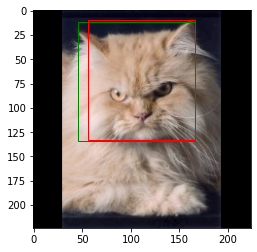

In [46]:

img,label,box = next(iter(val_dataloader))
img,label,box = img.to(device),label.to(device),box.to(device)
idx = 25 
with torch.no_grad():
    y_label,y_bbox = model(img)
img = denormalize(img[idx]).squeeze(axis=0).permute(1,2,0)
xmin,ymin,width,height = box[idx][0].cpu().numpy().astype(np.uint8),box[idx][1].cpu().numpy().astype(np.uint8),(box[idx][2]-box[idx][0]).cpu().numpy().astype(np.uint8),(box[idx][3]-box[idx][1]).cpu().numpy().astype(np.uint8)
fig,ax = plt.subplots(1)
ax.imshow(img.cpu())
rect = patches.Rectangle((xmin,ymin),width,height,linewidth=1,edgecolor='g',facecolor='none')
ax.add_patch(rect)
xmin,ymin,width,height = y_bbox[idx][0].cpu().numpy().astype(np.uint8),y_bbox[idx][1].cpu().numpy().astype(np.uint8),(y_bbox[idx][2]-y_bbox[idx][0]).cpu().numpy().astype(np.uint8),(y_bbox[idx][3]-y_bbox[idx][1]).cpu().numpy().astype(np.uint8)
rect = patches.Rectangle((xmin,ymin),width,height,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [47]:
res = 0
for images,labels,bboxes in val_dataloader:
    with torch.no_grad():
        y_labels,y_bboxes = model(images.to(device))

In [29]:
labels

tensor([16, 31, 11,  1, 18,  5,  3, 21, 14,  4, 19,  8, 20, 19,  2, 12, 28, 33,
        32, 23,  4, 16, 16, 20, 21,  7, 36,  7, 33, 21, 35])

In [48]:
y_labels.argmax(dim=1)

tensor([16, 31, 11,  1, 18,  0,  3, 21, 14,  3, 19,  8, 23, 19,  2, 12, 28, 33,
        32, 23,  8, 16, 16, 20, 21,  7, 36,  7, 33, 21, 35], device='cuda:0')

In [49]:
def freeze_classification(input_model):
    for param in input_model.fc_classification.parameters():
        param.requires_grad = False

In [50]:
freeze_classification(model)

In [ ]:
ONLY_BBOX = True
for epoch in tqdm(range(50)):
    train_loss, train_acc,train_iou = train_step(model,
                                                 train_dataloader,
                                                 classification_loss_fn,
                                                 regression_loss_fn,
                                                 optimizer,
                                                 device,
                                                 ONLY_BBOX,
                                                 GRAD_CLIP)
    print(f"{epoch} : train_loss {train_loss} | train_acc {train_acc} | train_iou {train_iou}")
    val_loss, val_acc, val_iou = test_step(model,
                                              val_dataloader,
                                              classification_loss_fn,
                                              regression_loss_fn,
                                              device,
                                              ONLY_BBOX)
    print(f"{epoch} : val_loss {val_loss} | val_acc {val_acc} | val_iou {val_iou}")
    if val_iou > TOTAL_VAL_IOU:
        TOTAL_VAL_IOU = val_iou
        save_model(model,"models","best_model.pth")

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0 : train_loss 4.4211496373881465 | train_acc 0.9913949275362318 | train_iou 0.7880737228669983


0it [00:00, ?it/s]

0 : val_loss 4.9668474197387695 | val_acc 0.9202368951612904 | val_iou 0.7620135689935377
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

1 : train_loss 4.419620977795643 | train_acc 0.9945652173913043 | train_iou 0.7880001750545225


0it [00:00, ?it/s]

1 : val_loss 4.947445392608643 | val_acc 0.915112567204301 | val_iou 0.7618419803598876


0it [00:00, ?it/s]

2 : train_loss 4.40419472300488 | train_acc 0.9959239130434783 | train_iou 0.7880519021680389


0it [00:00, ?it/s]

2 : val_loss 5.098704377810161 | val_acc 0.9164146505376344 | val_iou 0.7566936671413401


0it [00:00, ?it/s]

3 : train_loss 4.383370166239531 | train_acc 0.9955842391304348 | train_iou 0.7893387707679168


0it [00:00, ?it/s]

3 : val_loss 5.0162830750147505 | val_acc 0.9177167338709676 | val_iou 0.7603170075403747


0it [00:00, ?it/s]

4 : train_loss 4.3789767026901245 | train_acc 0.993546195652174 | train_iou 0.789566411704257


0it [00:00, ?it/s]

4 : val_loss 5.167994419733684 | val_acc 0.915112567204301 | val_iou 0.7534250333424537


0it [00:00, ?it/s]

5 : train_loss 4.2867603612982705 | train_acc 0.9944519927536232 | train_iou 0.7919345480808313


0it [00:00, ?it/s]

5 : val_loss 5.020948767662048 | val_acc 0.919018817204301 | val_iou 0.7587216115126045


0it [00:00, ?it/s]

6 : train_loss 4.396707653999329 | train_acc 0.9921875 | train_iou 0.7891363959381547


0it [00:00, ?it/s]

6 : val_loss 4.971642931302388 | val_acc 0.915028561827957 | val_iou 0.7623703601539775
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

7 : train_loss 4.369716963042384 | train_acc 0.9918478260869565 | train_iou 0.7892803193434424


0it [00:00, ?it/s]

7 : val_loss 5.161470691363017 | val_acc 0.9163306451612904 | val_iou 0.7554306892618056


0it [00:00, ?it/s]

8 : train_loss 4.301664619342141 | train_acc 0.9952445652173914 | train_iou 0.791235934133115


0it [00:00, ?it/s]

8 : val_loss 5.025807181994121 | val_acc 0.915028561827957 | val_iou 0.7587455600820562


0it [00:00, ?it/s]

9 : train_loss 4.202144804208175 | train_acc 0.9925271739130435 | train_iou 0.7952515377082687


0it [00:00, ?it/s]

9 : val_loss 5.013205011685689 | val_acc 0.9138104838709676 | val_iou 0.7602808983415685


0it [00:00, ?it/s]

10 : train_loss 4.242392806903176 | train_acc 0.9928668478260869 | train_iou 0.7943673790365026


0it [00:00, ?it/s]

10 : val_loss 5.107954621315002 | val_acc 0.9176327284946236 | val_iou 0.7555337963245248


0it [00:00, ?it/s]

11 : train_loss 4.2134495533030965 | train_acc 0.9928668478260869 | train_iou 0.7955451609863751


0it [00:00, ?it/s]

11 : val_loss 5.035779237747192 | val_acc 0.9085181451612904 | val_iou 0.7594250089699223


0it [00:00, ?it/s]

12 : train_loss 4.26161058311877 | train_acc 0.9949048913043478 | train_iou 0.7936858085618503


0it [00:00, ?it/s]

12 : val_loss 5.176156202952067 | val_acc 0.9137264784946236 | val_iou 0.7550057183991196


0it [00:00, ?it/s]

Epoch 00089: reducing learning rate of group 0 to 1.0240e-04.
13 : train_loss 4.2132103132165 | train_acc 0.9938858695652174 | train_iou 0.7948558574569399


0it [00:00, ?it/s]

13 : val_loss 4.919451355934143 | val_acc 0.9177167338709676 | val_iou 0.7635714225871588
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

14 : train_loss 4.107266902923584 | train_acc 0.9944519927536232 | train_iou 0.7994931709507237


0it [00:00, ?it/s]

14 : val_loss 4.995234688123067 | val_acc 0.918934811827957 | val_iou 0.7608965212298978


0it [00:00, ?it/s]

15 : train_loss 4.082957412885583 | train_acc 0.9942255434782609 | train_iou 0.7999610486237899


0it [00:00, ?it/s]

15 : val_loss 4.968740622202556 | val_acc 0.915112567204301 | val_iou 0.7619947521917282


0it [00:00, ?it/s]

16 : train_loss 4.0472851784332935 | train_acc 0.9934329710144927 | train_iou 0.800704078613848


0it [00:00, ?it/s]

16 : val_loss 4.930887063344319 | val_acc 0.9203209005376344 | val_iou 0.7639646717617589
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

In [44]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjLocModel (ObjLocModel)                     [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (backbone)                       [32, 3, 224, 224]    [32, 2048, 7, 7]     --                   False
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (1)                        [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (2)                               [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (4)                         [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56,